In [2]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from decision_tree import DecisionTree as DecisionTree
from DecisionTree.decision_tree import DecisionTree as DecisionTreeOG
from AdaBoost import AdaBoostTree
from BaggedTrees import BaggedTrees, RandomForest
import matplotlib.pyplot as plt

In [3]:
def test_tree_accuracy(decision_tree, test_data):
    preds = test_data.apply(lambda row : decision_tree.predict(row), axis=1)
    diff = preds == test_data['label']
    if (diff == True).all():
        return 0
    else:
        error_count = diff.value_counts()[False]
        return error_count / len(test_data)

In [4]:
def process_data(df, attributes, replace_unknown=False, map_labels=True):
    #If specified, replace all 'uknown' values with column majority
    if replace_unknown:
        for attribute in attributes:
            if df[attribute].dtype.kind not in 'iufc':
                most_common = 'unknown'
                counts = df[attribute].value_counts()
                if counts[[0]].index[0] == 'unknown' and len(counts) > 1:
                    most_common = counts[[1]].index[0]
                else:
                    most_common = counts[[0]].index[0]
                df[attribute][df[attribute] == 'unknown'] = most_common
    
    #Replace numerical columns with boolean values based on median threshold
    for attribute in attributes:
        if df[attribute].dtype.kind in 'iufc':
            median = df[attribute].median()
            binary_col = df[attribute] > median
            df[attribute] = binary_col

    if map_labels:
        df.label[df.label == 'yes'] = 1
        df.label[df.label == 'no'] = -1
            
    return df

In [5]:
attributes = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 
'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']

df_train = pd.read_csv('../data/bank/train.csv', names=attributes + ['label'])
df_test = pd.read_csv('../data/bank/test.csv', names=attributes + ['label'])

df_train = process_data(df_train, attributes, replace_unknown=False)
df_test = process_data(df_test, attributes, replace_unknown=False)

In [ ]:
#Test AdaBoost
training_errors_ab = []
test_errors_ab = []
T = [1, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500]
adaboost_predictors = []

for t in T:
    adaboost = AdaBoostTree(df_train, attributes)
    adaboost.build_model(t)
    training_errors_ab.append(test_tree_accuracy(adaboost, df_train))
    test_errors_ab.append(test_tree_accuracy(adaboost, df_test))
    adaboost_predictors.append(adaboost)


In [29]:
print(test_tree_accuracy(adaboost_predictors[-1], df_train))
print(test_tree_accuracy(adaboost_predictors[-1], df_test))

0.1028
0.1076


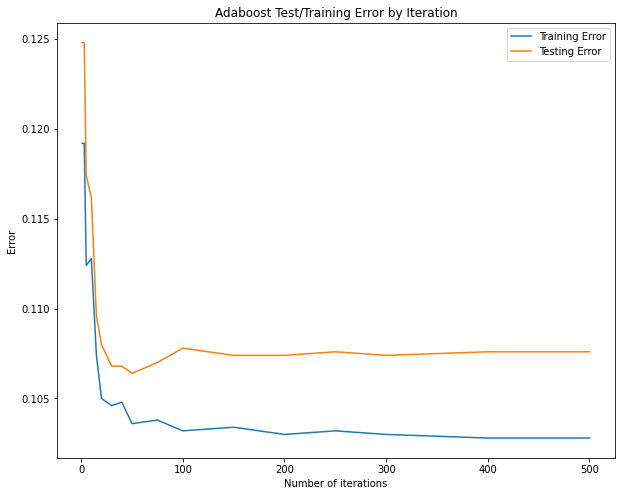

In [37]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.plot(T, training_errors_ab, label='Training Error')
plt.plot(T, test_errors_ab, label='Testing Error')
plt.title('Adaboost Test/Training Error by Iteration')
plt.xlabel('Number of iterations')
plt.ylabel('Error')
plt.legend()

In [22]:
training_errors_stumps = []
testing_errors_stumps = []
for i, predictor in enumerate(adaboost_predictors):
    training_errors_stumps_iter = []
    testing_errors_stumps_iter = []
    for stump in predictor.classifiers:
        training_errors_stumps_iter.append(test_tree_accuracy(stump, df_train))
        testing_errors_stumps_iter.append(test_tree_accuracy(stump, df_test))
    training_errors_stumps.append(training_errors_stumps_iter)
    testing_errors_stumps.append(testing_errors_stumps_iter)

Text(0, 0.5, 'Error')

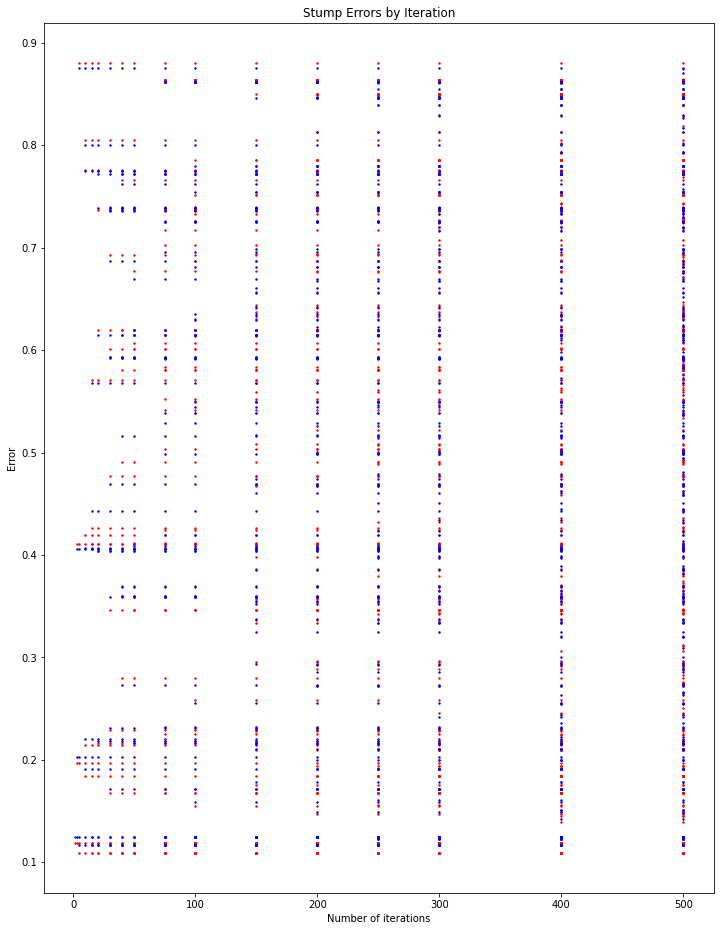

In [36]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(16)

for i, iter_errors in enumerate(training_errors_stumps):
    for error in iter_errors:
        plt.scatter(T[i], error, c='r', s=2)
for i, iter_errors in enumerate(testing_errors_stumps):
    for error in iter_errors:
        plt.scatter(T[i], error,  c='b', s=2)

# plt.plot(T, training_errors_stumps, label='Training Error')
# plt.plot(T, testing_errors_stumps, label='Testing Error')
plt.title('Stump Errors by Iteration')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

Text(0, 0.5, 'Error')

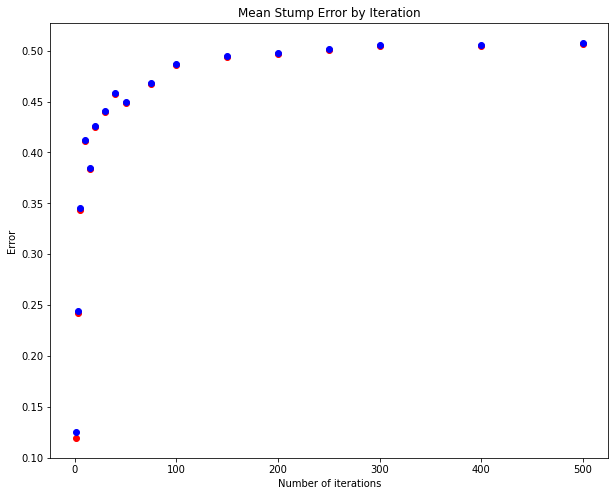

In [35]:
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)

for i, iter_errors in enumerate(training_errors_stumps):
    mean = sum(iter_errors) / len(iter_errors)
    plt.scatter(T[i], mean, label='Training Error', c='r')
for i, iter_errors in enumerate(testing_errors_stumps):
    mean = sum(iter_errors) / len(iter_errors)
    plt.scatter(T[i], mean, label='Testing Error', c='b')

plt.title('Mean Stump Error by Iteration')
plt.xlabel('Number of iterations')
plt.ylabel('Error')

In [ ]:
#Test Bagged Trees
training_errors = []
test_errors = []
T = [1, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500]

for t in T:
    bagged_trees = BaggedTrees(df_train, attributes)
    bagged_trees.build_trees(t)
    training_errors.append(test_tree_accuracy(bagged_trees, df_train))
    test_errors.append(test_tree_accuracy(bagged_trees, df_test)) 


In [ ]:
textfile = open("training_errs_bt.txt", "w")
for element in training_errors:
    textfile.write(str(element) + ", ")
textfile.close()

In [ ]:
textfile = open("test_errs_bt.txt", "w")
for element in test_errors:
    textfile.write(str(element) + ", ")
textfile.close()

In [49]:
#Test original decision tree
dtree_nolimit = DecisionTree(df_train, attributes).build_tree('entropy', float('inf'))
dtree_best = DecisionTree(df_train, attributes).build_tree('entropy', 3)


In [ ]:
print('No limit tree accuracy on test: %f' % test_tree_accuracy(dtree_nolimit, df_test))
print('No limit tree accuracy on train: %f' % test_tree_accuracy(dtree_nolimit, df_train))

print('Best tree accuracy on test: %f' % test_tree_accuracy(dtree_best, df_test))
print('Best tree accuracy on train: %f' % test_tree_accuracy(dtree_best, df_train))

In [ ]:
#Bagged Trees bias/variance decomposition
num_trees = 500
num_samples = 1000
bagged_predictors = []

for i in range(2):
    bagged_trees = BaggedTrees(df_train, attributes)
    bagged_trees.build_trees(num_trees, num_samples)
    bagged_predictors.append(bagged_trees)


In [47]:
single_trees = [predictor.trees[0] for predictor in bagged_predictors]
single_tree_biases = []
single_tree_variances = []
ctr = 0
for idx, row in df_test.iterrows():
    preds = []
    for tree in single_trees:
        try:
            pred = tree.predict(row)
        except:
            ctr+=1
            continue
        preds.append(pred)
    preds = np.asarray(preds)
    avg_pred = np.mean(preds)
    bias = (avg_pred - row['label'])**2
    single_tree_biases.append(bias)
    var = np.var(preds)
    single_tree_variances.append(var)
single_tree_bias = sum(single_tree_biases) / len(single_tree_biases)
single_tree_var = sum(single_tree_variances) / len(single_tree_variances)
single_tree_squared_err = single_tree_bias + single_tree_var
print(ctr)

bagged_tree_biases = []
bagged_tree_variances = []
ctr = 0
for idx, row in df_test.iterrows():
    preds = []
    for predictor in bagged_predictors:
        try:
            pred = predictor.predict(row)
        except:
            ctr+=1
            continue
        preds.append(pred)
    preds = np.asarray(preds)
    avg_pred = np.mean(preds)
    bias = (avg_pred - row['label'])**2
    if np.isnan(bias):
        print(preds)
        print(avg_pred)
        print(row['label'])
        break
    bagged_tree_biases.append(bias)
    var = np.var(preds)
    bagged_tree_variances.append(var)
print(ctr)
bagged_trees_bias = sum(bagged_tree_biases) / len(bagged_tree_biases)
bagged_trees_var = sum(bagged_tree_variances) / len(bagged_tree_variances)
bagged_trees_squared_err = bagged_trees_bias + bagged_trees_var


0
[]
nan
-1
2


C:\Users\Gabrielius Kudirka\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Gabrielius Kudirka\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [43]:
bagged_tree_biases = np.asarray(bagged_tree_biases)
bagged_tree_variances = np.asarray(bagged_tree_variances)

bagged_tree_biases = bagged_tree_biases[~np.isnan(bagged_tree_biases)]
bagged_tree_variances = bagged_tree_variances[~np.isnan(bagged_tree_variances)]

bagged_trees_bias = sum(bagged_tree_biases) / len(bagged_tree_biases)
bagged_trees_var = sum(bagged_tree_variances) / len(bagged_tree_variances)
bagged_trees_squared_err = bagged_trees_bias + bagged_trees_var

In [46]:
print('Single Trees Bias: %f' % single_tree_bias)
print('Single Trees Variance: %f' % single_tree_var)
print('Single Trees Estimated Squared Error: %f' % single_tree_squared_err)

print('Bagged Trees Bias: %f' % bagged_trees_bias)
print('Bagged Trees Variance: %f' % bagged_trees_var)
print('Bagged Trees Estimated Squared Error: %f' % bagged_trees_squared_err)

Single Trees Bias: 0.505200
Single Trees Variance: 0.194000
Single Trees Estimated Squared Error: 0.699200
Bagged Trees Bias: 0.438843
Bagged Trees Variance: 0.117493
Bagged Trees Estimated Squared Error: 0.556337


In [ ]:
#Test Random Forest
training_errors_rf = {}
test_errors_rf = {}
T = [1, 3, 5, 10, 15, 20, 30, 40, 50, 75, 100, 150, 200, 250, 300, 400, 500]
subset_sizes = [2, 4, 6]

for subset_size in subset_sizes:
    training_errors_rf[subset_size] = []
    test_errors_rf[subset_size] = []
    for t in T:
        random_forest = RandomForest(df_train, attributes)
        random_forest.build_trees(t, subset_size)
        training_errors_rf[subset_size].append(test_tree_accuracy(random_forest, df_train))
        test_errors_rf[subset_size].append(test_tree_accuracy(random_forest, df_test))


In [ ]:
import json

with open('training_errs_rf.txt', 'w') as convert_file:
     convert_file.write(json.dumps(training_errors_rf))

with open('test_errors_rf_rf.txt', 'w') as convert_file:
     convert_file.write(json.dumps(test_errors_rf))

In [10]:
#Random Forest bias/variance decomposition
num_trees = 110
num_samples = 800
rf_predictors = []
ctr = 0
for i in range(20):
    random_forest = RandomForest(df_train, attributes)
    random_forest.build_trees(num_trees, 2, num_samples)
    rf_predictors.append(random_forest)
    ctr += 1
    print(ctr)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [11]:
single_trees = [predictor.trees[0] for predictor in rf_predictors]
single_tree_biases = []
single_tree_variances = []
ctr = 0
for idx, row in df_test.iterrows():
    preds = []
    for tree in single_trees:
        try:
            pred = tree.predict(row)
        except:
            ctr+=1
            continue
        preds.append(pred)
    preds = np.asarray(preds)
    avg_pred = np.mean(preds)
    bias = (avg_pred - row['label'])**2
    single_tree_biases.append(bias)
    var = np.var(preds)
    single_tree_variances.append(var)
single_tree_bias = sum(single_tree_biases) / len(single_tree_biases)
single_tree_var = sum(single_tree_variances) / len(single_tree_variances)
single_tree_squared_err = single_tree_bias + single_tree_var
print(ctr)

bagged_tree_biases = []
bagged_tree_variances = []
ctr = 0
for idx, row in df_test.iterrows():
    preds = []
    for predictor in rf_predictors:
        try:
            pred = predictor.predict(row)
        except:
            ctr+=1
            continue
        preds.append(pred)
    preds = np.asarray(preds)
    avg_pred = np.mean(preds)
    bias = (avg_pred - row['label'])**2
    if np.isnan(bias):
        print(preds)
        print(avg_pred)
        print(row['label'])
        break
    bagged_tree_biases.append(bias)
    var = np.var(preds)
    bagged_tree_variances.append(var)
print(ctr)
bagged_trees_bias = sum(bagged_tree_biases) / len(bagged_tree_biases)
bagged_trees_var = sum(bagged_tree_variances) / len(bagged_tree_variances)
bagged_trees_squared_err = bagged_trees_bias + bagged_trees_var


3
850


In [12]:
bagged_tree_biases = np.asarray(bagged_tree_biases)
bagged_tree_variances = np.asarray(bagged_tree_variances)

bagged_tree_biases = bagged_tree_biases[~np.isnan(bagged_tree_biases)]
bagged_tree_variances = bagged_tree_variances[~np.isnan(bagged_tree_variances)]

bagged_trees_bias = sum(bagged_tree_biases) / len(bagged_tree_biases)
bagged_trees_var = sum(bagged_tree_variances) / len(bagged_tree_variances)
bagged_trees_squared_err = bagged_trees_bias + bagged_trees_var

In [13]:
#Print and save results
print('Single Trees Bias: %f' % single_tree_bias)
print('Single Trees Variance: %f' % single_tree_var)
print('Single Trees Estimated Squared Error: %f' % single_tree_squared_err)

print('Random Forest Bias: %f' % bagged_trees_bias)
print('Random Forest Variance: %f' % bagged_trees_var)
print('Random Forest Estimated Squared Error: %f' % bagged_trees_squared_err)


Single Trees Bias: 0.365423
Single Trees Variance: 0.318543
Single Trees Estimated Squared Error: 0.683966
Random Forest Bias: 0.430535
Random Forest Variance: 0.061495
Random Forest Estimated Squared Error: 0.492030
